# Tutorial 9: Unsupervised Learning Applications (2)

## **Exercise:** Anomaly Detection in Semiconductor Manufacturing
*Source: [Ankur Kumar, Jesus Flores-Cerrillo, 2022. Machine Learning in Python for Process Systems Engineering](https://github.com/ML-PSE/Machine_Learning_for_PSE)*

**Problem Overview:**
A semiconductor etching process is crucial for chip production, and maintaining consistent operation is essential. Anomalies in this process can lead to faulty batches. We have historical data from both normal and faulty batches, but the data exhibits high dimensionality (19 process variables).

**Objective:**

- Analyze the process data to determine if it exhibits multimodality using GMMs. Multimodality refers to the presence of distinct operational modes within the data. 
- Once the GMM model is trained, use the model for anomaly detection using the anomaly scores of datapoints.

**Data:**

The dataset consists of measurements from a semiconductor etching process, including:

* **Process Variables:** 19 measurements taken throughout the etching process for each batch.
* **Batch Labels:** Labels indicating normal (108 batches) or faulty (21 batches) batches.

By understanding if the data exhibits multimodality, we can potentially develop a more effective model to distinguish normal and faulty batches in the future. This will be crucial for improving process monitoring and ensuring consistent chip quality. 


<hr width="50%" style="margin-top: 2rem; margin-bottom: 2rem; margin-left:0">

### Step 1: load normal operation data

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
# load normal data
df = pd.read_csv('metal_etch_train.csv', header=None)

# TODO: print the shape of the dataframe
df.shape


(107, 1615)

<hr width="50%" style="margin-top: 2rem; margin-bottom: 2rem; margin-left:0">

### Step 2: perform dimensionality reduction and visualize PCs

In [3]:
# import the necessary modules for the selected model
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# TODO: create and fit a pipeline for scaling and dimensionality reduction using PCA (use 3 components)
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components = 3))
])
data_pca = pipe.fit_transform(df)

# TODO: create a dataframe from the fitted data and add a class colum =0
df_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2', 'PC3'])
df_pca['class'] = 0

# TODO: visualize the data
fig = px.scatter_3d(df_pca, x='PC1', y='PC2', z='PC3')
fig.update_traces(marker=dict(size=5))
fig.update_layout(width=1000, height=1000)
fig.show()


<hr width="50%" style="margin-top: 2rem; margin-bottom: 2rem; margin-left:0">

### Step 3: load faulty data, process, and visualize

In [4]:
# load faulty data
df_test = pd.read_csv('metal_etch_test.csv', header=None)

# TODO: scale and PCA on faulty test data and assign a class =1
data_pca_test = pipe.transform(df_test)
df_pca_test = pd.DataFrame(data_pca_test, columns=['PC1', 'PC2', 'PC3'])
df_pca_test['class'] = 1

# TODO: combine the normal and faulty data into one dataframe
df_pca_combined = pd.concat([df_pca, df_pca_test])

# TODO: visualize the data
fig = px.scatter_3d(df_pca_combined, x='PC1', y='PC2', z='PC3', color='class')
fig.update_traces(marker=dict(size=5))
fig.update_layout(width=1000, height=1000)
fig.show()

<hr width="50%" style="margin-top: 2rem; margin-bottom: 2rem; margin-left:0">

### Step 4: build and train a GMM for anomaly detection

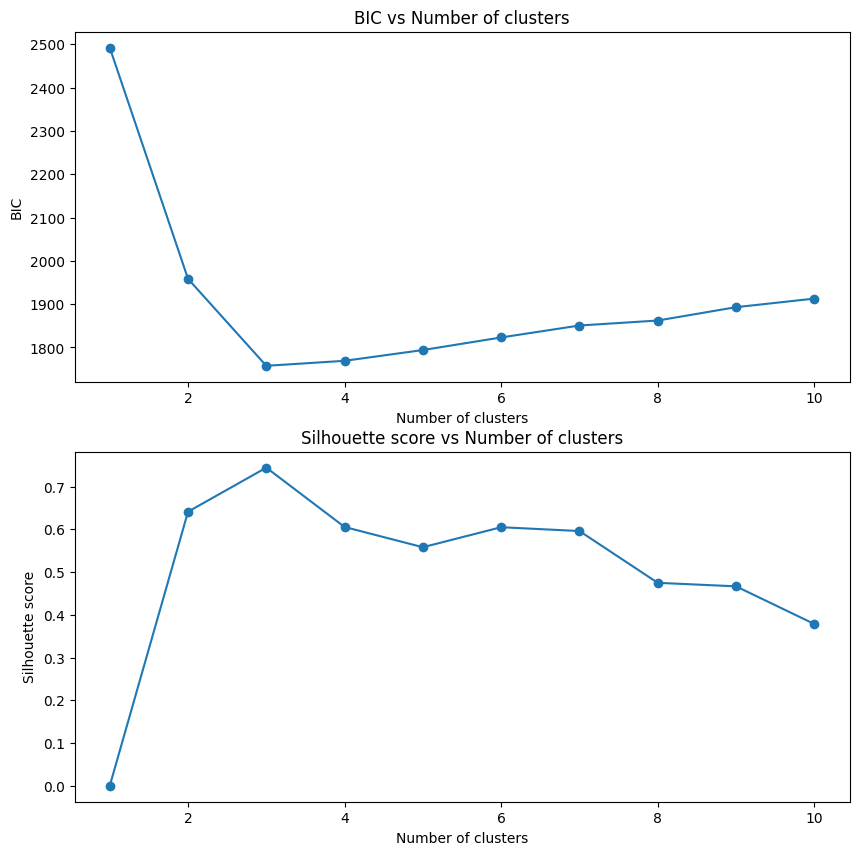

In [5]:
# TODO: determine the optimal number of clusters using the BIC elbow method for GMM
# train the model using only normal conditions data 
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

BICs = []
silhouettes = [0]
X = df_pca.drop('class', axis=1)
for i in range(1, 11):
    gmm = GaussianMixture(n_components=i)
    gmm.fit(X)
    BICs.append(gmm.bic(X))
    if i > 1:
        silhouettes.append(silhouette_score(X, gmm.predict(X)))

# plot the BICs
# subplot 1: BIC
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(range(1, 11), BICs, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('BIC')
plt.title('BIC vs Number of clusters')

# subplot 2: silhouette score
plt.subplot(2, 1, 2)
plt.plot(range(1, 11), silhouettes, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette score vs Number of clusters')

plt.show()

In [6]:
# TODO: build the GMM model with the optimum number of components
gmm = GaussianMixture(n_components=3, random_state=42)

# TODO: train the model using only the normal data
X = df_pca.drop('class', axis=1)
gmm.fit(X)

GaussianMixture(n_components=3, random_state=42)

<hr width="50%" style="margin-top: 2rem; margin-bottom: 2rem; margin-left:0">

### Step 5: anomaly detection using the trained GMM

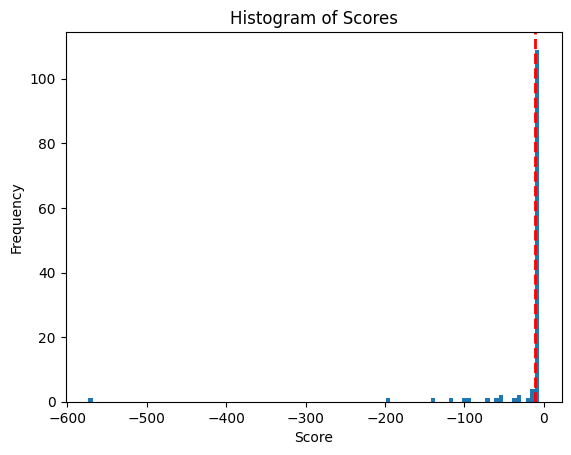

In [7]:
# TODO: 1. calculate the anomaly scores for the combined data
df_pca_combined['score'] = gmm.score_samples(df_pca_combined[['PC1', 'PC2', 'PC3']])

# TODO: visualize the scores using a histogram
plt.hist(df_pca_combined['score'], bins=100)
plt.axvline(np.percentile(df_pca_combined['score'], 15), color='red', linestyle='dashed', linewidth=2)
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Histogram of Scores')
plt.show()

In [8]:
# TODO: 2. set threshold
threshold = np.percentile(df_pca_combined['score'], 15)

# TODO: 3. predict anomalies
df_pca_combined['anomaly'] = df_pca_combined['score'] < threshold

# TODO: visualize the data
fig = px.scatter_3d(df_pca_combined, x='PC1', y='PC2', z='PC3', color='anomaly')
fig.update_traces(marker=dict(size=5))
fig.update_layout(width=1000, height=1000)
fig.show()

# TODO: print classification report
from sklearn.metrics import classification_report
print(classification_report(df_pca_combined['class'], df_pca_combined['anomaly']))


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       107
           1       0.95      0.90      0.92        20

    accuracy                           0.98       127
   macro avg       0.96      0.95      0.95       127
weighted avg       0.98      0.98      0.98       127



<hr width="50%" style="margin-top: 2rem; margin-bottom: 2rem; margin-left:0">

### Step 6: visualizing model's accuracy `(BONUS!)`

In [9]:
# TODO: initialize a column for the confusion matrix with default value = True Negative (TN)
df_pca_combined['confusion'] = 'TN'

# TODO: update the confusion matrix values based on the actual and predicted classes (True Positive, False Positive, True Negative, False Negative)
df_pca_combined['confusion'][(df_pca_combined['class'] == 0) & (df_pca_combined['anomaly'] == False)] = 'TN'
df_pca_combined['confusion'][(df_pca_combined['class'] == 0) & (df_pca_combined['anomaly'] == True)] = 'FP'
df_pca_combined['confusion'][(df_pca_combined['class'] == 1) & (df_pca_combined['anomaly'] == False)] = 'FN'
df_pca_combined['confusion'][(df_pca_combined['class'] == 1) & (df_pca_combined['anomaly'] == True)] = 'TP'

# TODO: visualize the confusion matrix
fig = px.scatter_3d(df_pca_combined, x='PC1', y='PC2', z='PC3', color='confusion')
fig.update_traces(marker=dict(size=5))
fig.update_layout(width=1000, height=1000)
fig.show()

C:\Users\chesa\AppData\Local\Temp\ipykernel_11356\3111846618.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\chesa\AppData\Local\Temp\ipykernel_11356\3111846618.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\chesa\AppData\Local\Temp\ipykernel_11356\3111846618.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\chesa\AppData\Local\Temp\ipykernel_11356\3111846618.py:8: SettingWithCopyWarning:


A value

<hr style="margin-top: 4rem;">
<h2>Author</h2>

<a href="https://github.com/SamerHany">Samer Hany</a>

<h2>References</h2>

- Ankur Kumar, Jesus Flores-Cerrillo, 2022. Machine Learning in Python for Process Systems Engineering
- https://github.com/ML-PSE/Machine_Learning_for_PSE